In [58]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import os
from google.colab import files
from google.colab import drive


Mounted at /content/drive
Done


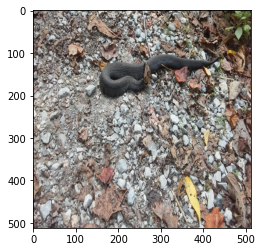

In [2]:
drive.mount('/content/drive')
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/15-classes.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

picture = plt.imread('/content/15-classes/train/20/0b103c4331bb47f4890d6e0ec96bf9bf.jpg')
imageShow = plt.imshow(picture)

In [3]:
resnet18Model=models.resnet18(pretrained=False)
num_filters = resnet18Model.fc.in_features
num_classes = 15 
resnet18Model.fc = nn.Linear(num_filters,num_classes)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(resnet18Model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18Model.to(device)
print("Device: {}".format(device))
resnet18Model.load_state_dict(torch.load('/content/15-class-100-epochos-output.pt'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0


<All keys matched successfully>

In [4]:

#import this file to train models and pass the  name of the datset
# extract zip files
# load the images and labels based on the dataset requested
# do the pre-processing , batch normalization , flip etc

# Transofrmations for preprocessedSnakeImages dataset
# Reference from https://www.youtube.com/watch?v=z3kB3ISIPAg&list=PL3Dh_99BJkCEhE7Ri8W6aijiEqm3ZoGRq&index=4
training_path = '/content/15-classes/train/'
test_path = '/content/15-classes/test'
val_path = '/content/15-classes/val'
def transformDS1( batchSize, inputSize):

    training_transforms = transforms.Compose([transforms.Resize((inputSize,inputSize)),transforms.ToTensor()])
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform = training_transforms)
    train_Loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batchSize,shuffle=False)
    mean, std = get_mean_std(train_Loader)
    train_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    test_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((inputSize,inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(root=training_path,transform=train_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path,transform=test_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_path,transform=val_transforms)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batchSize,
    shuffle=True,drop_last=False,num_workers=0)

    return train_loader,data_loader_test,val_loader

def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std


In [5]:
train_loader,test_loader,val_loader = transformDS1(32,224)


In [6]:
def get_representations(model, iterator):
    model.eval()
    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)
    return outputs, labels


In [7]:
outputs, labels = get_representations(resnet18Model, train_loader)

In [13]:
from sklearn import manifold

def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [14]:
def plot_representations(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


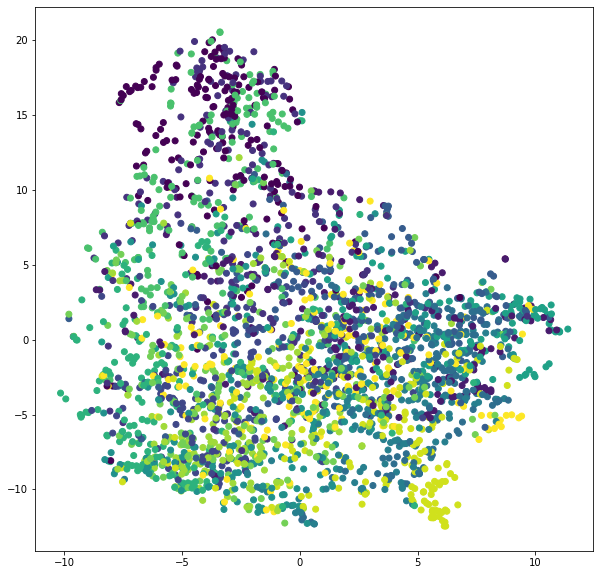

In [15]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels)

In [ ]:
output_tsne_data = get_tsne(outputs,n_components=3)


In [82]:
def plot_representations_3d(data, labels, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    # fig, ax = plt.subplots(figsize=(10,10))
    fig = plt.figure(figsize = (16, 16))
    ax = fig.add_subplot(111,projection = '3d')
    colormap = np.array(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000'])
    scatter = ax.scatter(data[:, 0], data[:, 1],data[:, 2] ,labels, c = colormap[labels],marker='*')


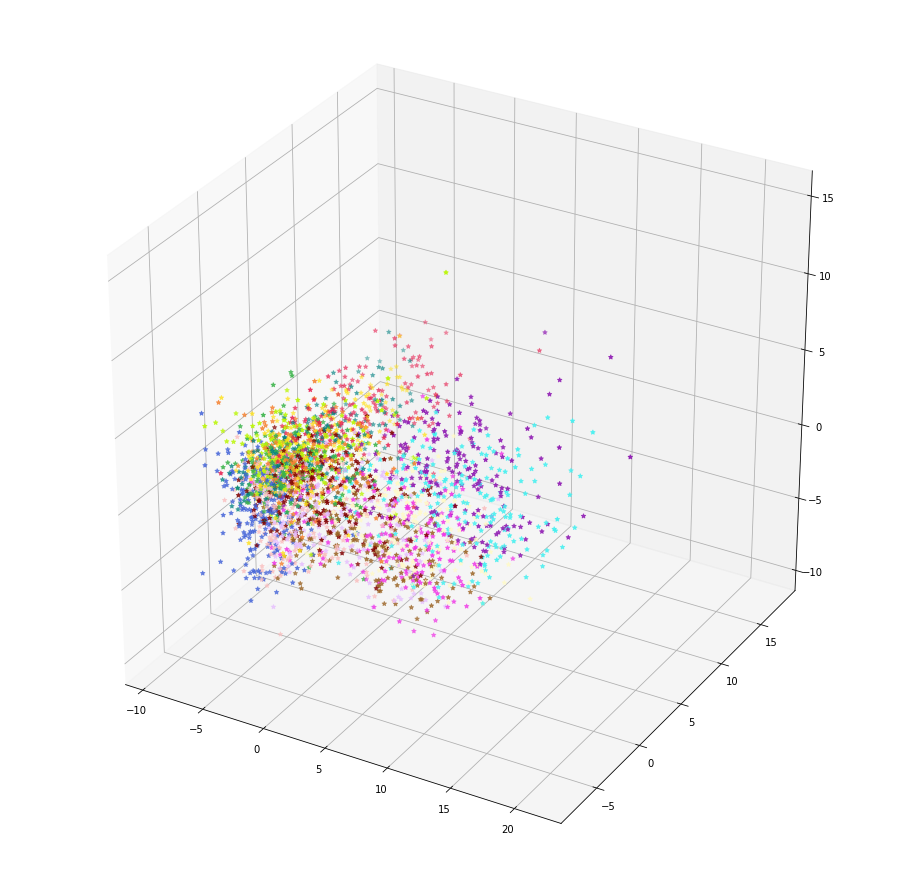

In [83]:
plot_representations_3d(output_tsne_data, labels)

In [38]:
from sklearn.decomposition import PCA

In [37]:

def get_pca(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    pca = PCA(n_components = n_components, random_state = 0)
    pca_data = pca.fit_transform(data)
    return pca_data

In [39]:
output_tsne_data = get_pca(outputs,n_components=3)


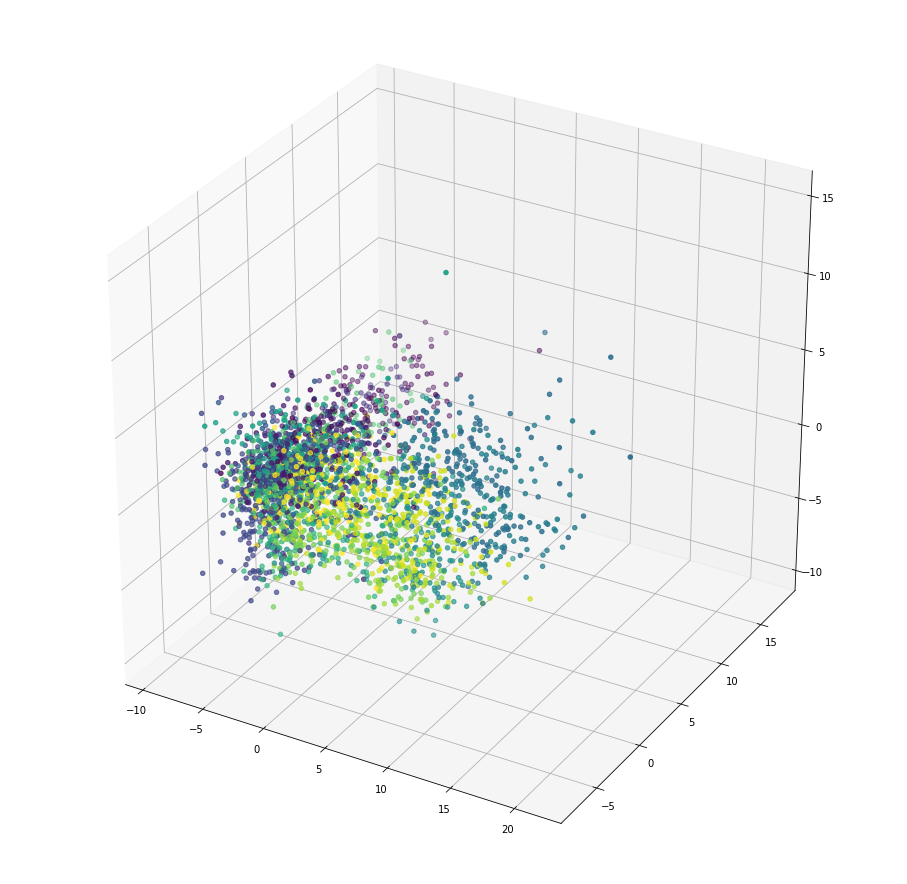

In [40]:
plot_representations_3d(output_tsne_data, labels)